##  Material for the course "Numerical Simulation of reactive flows"  
Author: Jun.-Prof. Federica Ferraro \
Technische Universität Braunschweig \
Institut für Flugantriebe und Strömungsmaschinen (IFAS)

Date: 30.11.2023

### Exercise 3 - Calculation of the Ignition Delay time
Documentation:\
https://cantera.org/dev/python/thermo.html \
https://cantera.org/examples/jupyter/reactors/batch_reactor_ignition_delay_NTC.ipynb.html

In [2]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
gas1 = ct.Solution('gri30.yaml')

In [40]:
def ignition_delay(states, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]

In [41]:
#Define reactor temperature and pressure 
r_T=1500 # Kelvin 
r_p= 101325 # Pascal

gas1.TP =r_T, r_p

#Define the composition
gas1.set_equivalence_ratio(phi=1.0, fuel="CH4", oxidizer={"O2": 1.0, "N2": 3.76})

In [42]:
# Create a reactor
r = ct.IdealGasReactor(contents=gas1, name="Batch Reactor")


#create a reactor network of 1 reactor 
reactor_network = ct.ReactorNet([r])

In [43]:
# use the above list to create a DataFrame
time_history = ct.SolutionArray(gas1, extra="t")

# set a reference species 
Y_ref ='OH'

# set start Time
t0 = time.time()

# set integration time
t_int=0.01 # seconds

t=0

counter = 1
while t < t_int:
    t = reactor_network.step()
    if not counter % 10:
        # We will save only every 10th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        time_history.append(r.thermo.state, t=t)
         #print(r.thermo.P)
    counter += 1
    
    
# Toc
t1 = time.time()

In [44]:
time_history;

In [45]:
# We will use the 'oh' species to compute the ignition delay
tau = ignition_delay(time_history, Y_ref)

print(f"Computed Ignition Delay: {tau:.3e} seconds. Execution Time: {t1-t0:3.2f}s.")

Computed Ignition Delay: 1.117e-03 seconds. Execution Time: 0.08s.


(0.0, 0.01)

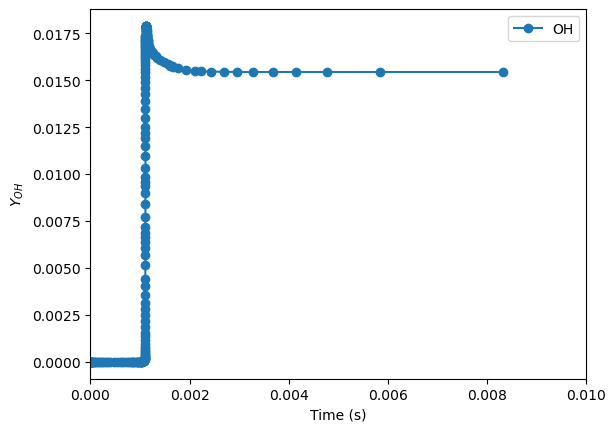

In [46]:
#plot
plt.figure()
plt.plot(time_history.t, time_history(Y_ref).Y, "-o", label='OH')
#plt.plot(time_history.t, time_history.D, "-", label='CH4')
plt.xlabel("Time (s)")
plt.ylabel("$Y_{OH}$")
plt.legend()
plt.xlim([0, 0.01])

(0.0, 0.003)

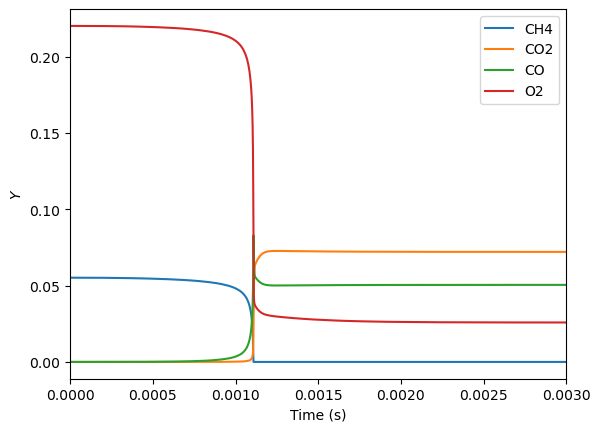

In [47]:
plt.plot(time_history.t, time_history('CH4').Y, "-", label='CH4')
plt.plot(time_history.t, time_history('CO2').Y, "-", label='CO2')
plt.plot(time_history.t, time_history('CO').Y, "-", label='CO')
plt.plot(time_history.t, time_history('O2').Y, "-", label='O2')
plt.xlabel("Time (s)")
plt.ylabel("$Y$")
plt.legend()
plt.xlim([0, 0.003])

Text(0, 0.5, '$T (K)$')

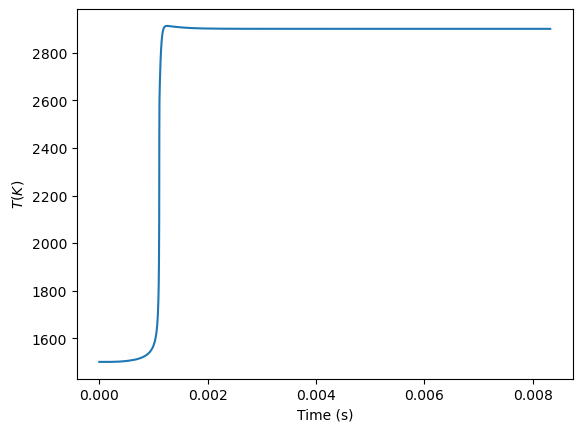

In [48]:
plt.plot(time_history.t, time_history.T, "-")
plt.xlabel("Time (s)")
plt.ylabel("$T (K)$")


In [49]:
T_points = 8
Temp_array = np.linspace(1100, 1800, T_points)

estimated_ignition_delay_times = np.ones_like(Temp_array, dtype=float)
estimated_ignition_delay_times[:] =1 #s

In [274]:
# Now create a SolutionArray out of these
ignition_delays = ct.SolutionArray(gas1, shape=Temp_array.shape, extra={"tau": estimated_ignition_delay_times})

ignition_delays.set_equivalence_ratio(phi=1.0, fuel="CH4", oxidizer={"O2": 1.0, "N2": 3.76})
ignition_delays.TP = Temp_array, r_p

In [275]:
for i, state in enumerate(ignition_delays):
    # Setup the gas and reactor
    gas1.TPX = state.TPX
    r = ct.IdealGasReactor(contents=gas1, name="Batch Reactor")
    reactor_network = ct.ReactorNet([r])

    reference_species_history = []
    time_history = []

    t0 = time.time()

    t = 0
    while t < estimated_ignition_delay_times[i]:
        t = reactor_network.step()
        time_history.append(t)
        reference_species_history.append(gas1[Y_ref].X[0])

    i_ign = np.array(reference_species_history).argmax()
    tau = time_history[i_ign]
    t1 = time.time()

    print(
        f"Computed Ignition Delay: {tau:.3e} seconds for T={state.T}K. Took {t1 - t0:3.2f}s to compute"
    )

    ignition_delays[i].tau = tau


Computed Ignition Delay: 1.306e+00 seconds for T=2618.921591466352K. Took 0.12s to compute
Computed Ignition Delay: 2.509e-01 seconds for T=2637.9363230963113K. Took 0.09s to compute
Computed Ignition Delay: 6.104e-02 seconds for T=2656.695949737382K. Took 0.07s to compute
Computed Ignition Delay: 1.941e-02 seconds for T=2675.1424285547296K. Took 0.06s to compute
Computed Ignition Delay: 7.978e-03 seconds for T=2693.236705880917K. Took 0.07s to compute
Computed Ignition Delay: 3.690e-03 seconds for T=2710.954562320166K. Took 0.07s to compute
Computed Ignition Delay: 1.811e-03 seconds for T=2728.2834099907386K. Took 0.05s to compute
Computed Ignition Delay: 1.033e-03 seconds for T=2745.219775798161K. Took 0.05s to compute


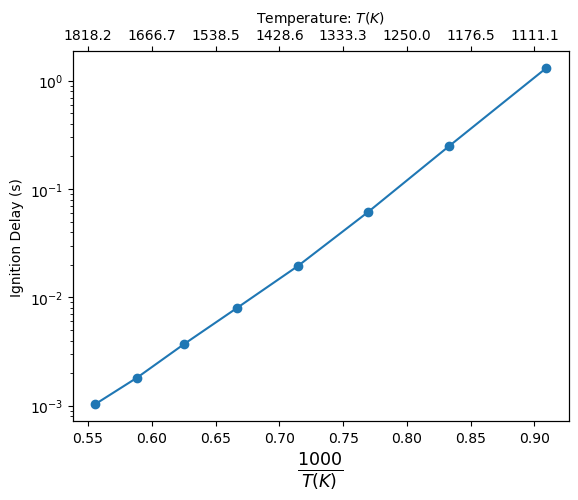

In [276]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000 / ignition_delays.T, ignition_delays.tau, "o-")
ax.set_ylabel("Ignition Delay (s)")
ax.set_xlabel(r"$\frac{1000}{T (K)}$", fontsize=18)

# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000 / ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel("Temperature: $T(K)$");

**Exercise:** 
1) Determine and plot the ignition delay time for the same mixture for p=0.1, 1 and 10 atm 
2) Determine and plot the ignition delay time for the same mixture for equivalence ratio 0.5 and 1.5

In [277]:
# Calculate ignition delay time for p= 0.1, 1 and 10 atm, phi=1
pressures = [0.1*ct.one_atm, ct.one_atm, 10*ct.one_atm]


#Define the composition

gas1.set_equivalence_ratio(phi=1.0, fuel="CH4", oxidizer={"O2": 1.0, "N2": 3.76})

T_points = 8
Temp_array = np.linspace(1100, 1800, T_points)

estimated_ignition_delay_times = np.ones_like(Temp_array, dtype=float)
estimated_ignition_delay_times[:] = 2 #s

# Now create a SolutionArray out of these
ignition_delays_phi1 = ct.SolutionArray(gas1, shape=Temp_array.shape, extra={"tau": estimated_ignition_delay_times})



In [278]:
ignition_delays_phi1_p=[]

for p_i in (pressures):
    ignition_delays_phi1.set_equivalence_ratio(phi=1.0, fuel="CH4", oxidizer={"O2": 1.0, "N2": 3.76})
    ignition_delays_phi1.TP = Temp_array, p_i
    
    for i, state in enumerate(ignition_delays_phi1):
        # Setup the gas and reactor
        T_init=state.T 
        gas1.TPX = state.TPX
        r = ct.IdealGasReactor(contents=gas1, name="Batch Reactor")
        reactor_network = ct.ReactorNet([r])

        reference_species_history = []
        time_history = []

        t0 = time.time()

        t = 0
        while t < estimated_ignition_delay_times[i]:
            t = reactor_network.step()
            time_history.append(t)
            reference_species_history.append(gas1[Y_ref].X[0])

        i_ign = np.array(reference_species_history).argmax()
        tau = time_history[i_ign]
        t1 = time.time()

        print(
            f"IDT: {tau:.3e} s for T={T_init}K, p={p_i}Pa. CPU Time {t1 - t0:3.2f}s"
        )

        ignition_delays_phi1_p.append(tau)


IDT: 1.306e+00 s for T=1100.0K, p=10132.5Pa. CPU Time 0.11s
IDT: 2.509e-01 s for T=1200.0K, p=10132.5Pa. CPU Time 0.08s
IDT: 6.104e-02 s for T=1300.0K, p=10132.5Pa. CPU Time 0.07s
IDT: 1.941e-02 s for T=1400.0K, p=10132.5Pa. CPU Time 0.06s
IDT: 7.978e-03 s for T=1500.0K, p=10132.5Pa. CPU Time 0.08s
IDT: 3.690e-03 s for T=1600.0K, p=10132.5Pa. CPU Time 0.05s
IDT: 1.811e-03 s for T=1700.0K, p=10132.5Pa. CPU Time 0.05s
IDT: 1.033e-03 s for T=1800.0K, p=10132.5Pa. CPU Time 0.06s
IDT: 1.980e-01 s for T=1100.0K, p=101325.0Pa. CPU Time 0.11s
IDT: 4.339e-02 s for T=1200.0K, p=101325.0Pa. CPU Time 0.08s
IDT: 1.108e-02 s for T=1300.0K, p=101325.0Pa. CPU Time 0.09s
IDT: 3.261e-03 s for T=1400.0K, p=101325.0Pa. CPU Time 0.08s
IDT: 1.119e-03 s for T=1500.0K, p=101325.0Pa. CPU Time 0.07s
IDT: 4.537e-04 s for T=1600.0K, p=101325.0Pa. CPU Time 0.06s
IDT: 2.152e-04 s for T=1700.0K, p=101325.0Pa. CPU Time 0.06s
IDT: 1.163e-04 s for T=1800.0K, p=101325.0Pa. CPU Time 0.07s
IDT: 1.673e-02 s for T=1100.0K, 

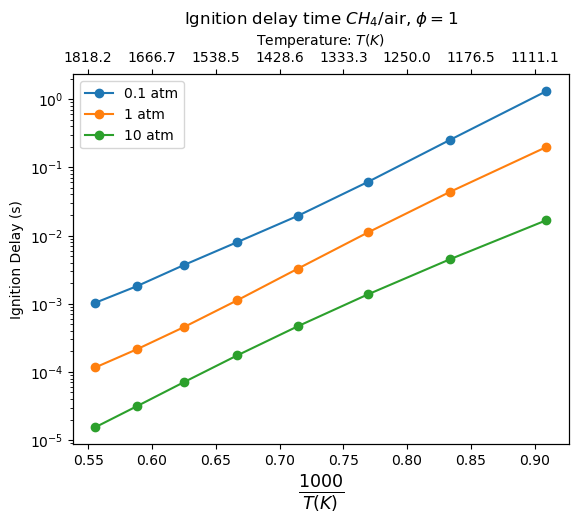

In [279]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000 / Temp_array, ignition_delays_phi1_p[:8], "o-",label='0.1 atm')
ax.set_ylabel("Ignition Delay (s)")
ax.set_xlabel(r"$\frac{1000}{T (K)}$", fontsize=18)


# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000 / ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel("Temperature: $T(K)$");

plt.title('Ignition delay time $CH_4$/air, $\phi=1$')
ax.plot(1000/Temp_array,ignition_delays_phi1_p[8:16], "o-", label='1 atm')
ax.plot(1000/Temp_array,ignition_delays_phi1_p[16:24], "o-", label='10 atm')
ax.legend()
fig.savefig('IDT_phi1.jpg', format='jpg')

In [280]:
# Calculation for phi = 0.5 and p = 0.5, 1 and 10 atm

estimated_ignition_delay_times = np.ones_like(Temp_array, dtype=float)
estimated_ignition_delay_times[:] = 2 #s

# Now create a SolutionArray out of these
ignition_delays_phi05 = ct.SolutionArray(gas1, shape=Temp_array.shape, extra={"tau": estimated_ignition_delay_times})

#phi=0.5
ignition_delays_phi05_p=[]

for p_i in (pressures):
    ignition_delays_phi05.set_equivalence_ratio(phi=0.50, fuel="CH4", oxidizer={"O2": 1.0, "N2": 3.76})
    ignition_delays_phi05.TP = Temp_array, p_i
    
    for i, state in enumerate(ignition_delays_phi05):
        # Setup the gas and reactor
        T_init=state.T 
        gas1.TPX = state.TPX
        r = ct.IdealGasReactor(contents=gas1, name="Batch Reactor")
        reactor_network = ct.ReactorNet([r])

        reference_species_history = []
        time_history = []

        t0 = time.time()

        t = 0
        while t < estimated_ignition_delay_times[i]:
            t = reactor_network.step()
            time_history.append(t)
            reference_species_history.append(gas1[Y_ref].X[0])

        i_ign = np.array(reference_species_history).argmax()
        tau = time_history[i_ign]
        t1 = time.time()

        print(
            f"IDT: {tau:.3e} s for T={T_init}K, p={p_i}Pa. CPU Time {t1 - t0:3.2f}s"
        )

        ignition_delays_phi05_p.append(tau)

IDT: 9.004e-01 s for T=1100.0K, p=10132.5Pa. CPU Time 0.09s
IDT: 1.757e-01 s for T=1200.0K, p=10132.5Pa. CPU Time 0.08s
IDT: 4.588e-02 s for T=1300.0K, p=10132.5Pa. CPU Time 0.07s
IDT: 1.634e-02 s for T=1400.0K, p=10132.5Pa. CPU Time 0.08s
IDT: 7.475e-03 s for T=1500.0K, p=10132.5Pa. CPU Time 0.07s
IDT: 4.021e-03 s for T=1600.0K, p=10132.5Pa. CPU Time 0.06s
IDT: 2.363e-03 s for T=1700.0K, p=10132.5Pa. CPU Time 0.06s
IDT: 1.413e-03 s for T=1800.0K, p=10132.5Pa. CPU Time 0.05s
IDT: 1.395e-01 s for T=1100.0K, p=101325.0Pa. CPU Time 0.10s
IDT: 3.060e-02 s for T=1200.0K, p=101325.0Pa. CPU Time 0.09s
IDT: 7.932e-03 s for T=1300.0K, p=101325.0Pa. CPU Time 0.09s
IDT: 2.452e-03 s for T=1400.0K, p=101325.0Pa. CPU Time 0.07s
IDT: 9.170e-04 s for T=1500.0K, p=101325.0Pa. CPU Time 0.07s
IDT: 4.118e-04 s for T=1600.0K, p=101325.0Pa. CPU Time 0.06s
IDT: 2.151e-04 s for T=1700.0K, p=101325.0Pa. CPU Time 0.08s
IDT: 1.269e-04 s for T=1800.0K, p=101325.0Pa. CPU Time 0.06s
IDT: 1.311e-02 s for T=1100.0K, 

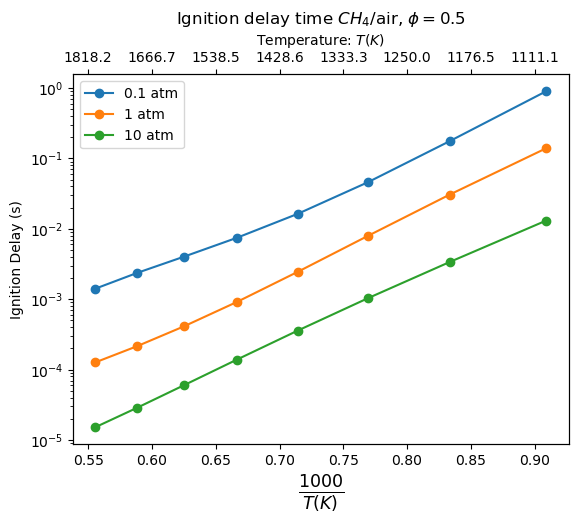

In [281]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000 / Temp_array, ignition_delays_phi05_p[:8], "o-",label='0.1 atm')
ax.set_ylabel("Ignition Delay (s)")
ax.set_xlabel(r"$\frac{1000}{T (K)}$", fontsize=18)


# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000 / ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel("Temperature: $T(K)$");

plt.title('Ignition delay time $CH_4$/air, $\phi=0.5$')
ax.plot(1000/Temp_array,ignition_delays_phi05_p[8:16], "o-", label='1 atm')
ax.plot(1000/Temp_array,ignition_delays_phi05_p[16:24], "o-", label='10 atm')
ax.legend()
fig.savefig('IDT_phi05.jpg', format='jpg',bbox_inches='tight')

In [282]:
# Calculation for phi=1.5 and p = 0.5, 1 and 10 atm

estimated_ignition_delay_times = np.ones_like(Temp_array, dtype=float)
estimated_ignition_delay_times[:] = 2 #s

# Now create a SolutionArray out of these
ignition_delays_phi15 = ct.SolutionArray(gas1, shape=Temp_array.shape, extra={"tau": estimated_ignition_delay_times})

#phi=0.5
ignition_delays_phi15_p=[]

for p_i in (pressures):
    ignition_delays_phi15.set_equivalence_ratio(phi=1.50, fuel="CH4", oxidizer={"O2": 1.0, "N2": 3.76})
    ignition_delays_phi15.TP = Temp_array, p_i
    
    for i, state in enumerate(ignition_delays_phi15):
        # Setup the gas and reactor
        T_init=state.T 
        gas1.TPX = state.TPX
        r = ct.IdealGasReactor(contents=gas1, name="Batch Reactor")
        reactor_network = ct.ReactorNet([r])

        reference_species_history = []
        time_history = []

        t0 = time.time()

        t = 0
        while t < estimated_ignition_delay_times[i]:
            t = reactor_network.step()
            time_history.append(t)
            reference_species_history.append(gas1[Y_ref].X[0])

        i_ign = np.array(reference_species_history).argmax()
        tau = time_history[i_ign]
        t1 = time.time()

        print(
            f"IDT: {tau:.3e} s for T={T_init}K, p={p_i}Pa. CPU Time {t1 - t0:3.2f}s"
        )

        ignition_delays_phi15_p.append(tau)

IDT: 1.627e+00 s for T=1100.0K, p=10132.5Pa. CPU Time 0.11s
IDT: 3.120e-01 s for T=1200.0K, p=10132.5Pa. CPU Time 0.10s
IDT: 7.340e-02 s for T=1300.0K, p=10132.5Pa. CPU Time 0.07s
IDT: 2.154e-02 s for T=1400.0K, p=10132.5Pa. CPU Time 0.07s
IDT: 9.435e-03 s for T=1500.0K, p=10132.5Pa. CPU Time 0.06s
IDT: 5.121e-03 s for T=1600.0K, p=10132.5Pa. CPU Time 0.08s
IDT: 3.212e-03 s for T=1700.0K, p=10132.5Pa. CPU Time 0.06s
IDT: 2.170e-03 s for T=1800.0K, p=10132.5Pa. CPU Time 0.06s
IDT: 2.441e-01 s for T=1100.0K, p=101325.0Pa. CPU Time 0.10s
IDT: 5.348e-02 s for T=1200.0K, p=101325.0Pa. CPU Time 0.11s
IDT: 1.360e-02 s for T=1300.0K, p=101325.0Pa. CPU Time 0.08s
IDT: 3.934e-03 s for T=1400.0K, p=101325.0Pa. CPU Time 0.09s
IDT: 1.299e-03 s for T=1500.0K, p=101325.0Pa. CPU Time 0.07s
IDT: 4.988e-04 s for T=1600.0K, p=101325.0Pa. CPU Time 0.07s
IDT: 2.228e-04 s for T=1700.0K, p=101325.0Pa. CPU Time 0.06s
IDT: 1.135e-04 s for T=1800.0K, p=101325.0Pa. CPU Time 0.06s
IDT: 2.033e-02 s for T=1100.0K, 

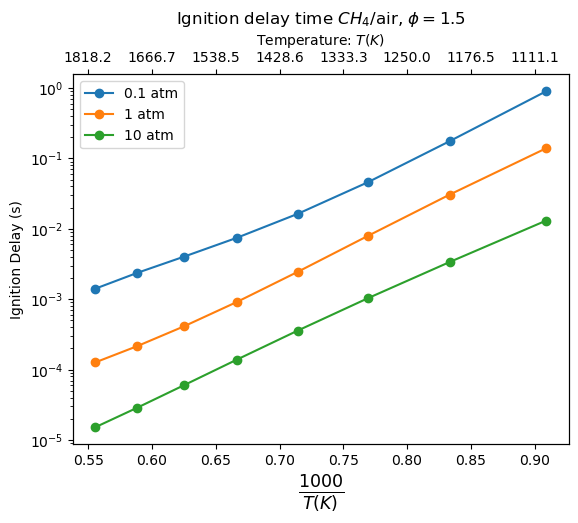

In [283]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000 / Temp_array, ignition_delays_phi05_p[:8], "o-",label='0.1 atm')
ax.set_ylabel("Ignition Delay (s)")
ax.set_xlabel(r"$\frac{1000}{T (K)}$", fontsize=18)


# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000 / ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel("Temperature: $T(K)$");

plt.title('Ignition delay time $CH_4$/air, $\phi=1.5$')
ax.plot(1000/Temp_array,ignition_delays_phi05_p[8:16], "o-", label='1 atm')
ax.plot(1000/Temp_array,ignition_delays_phi05_p[16:24], "o-", label='10 atm')
ax.legend()
fig.savefig('IDT_phi15.jpg', format='jpg',bbox_inches='tight')

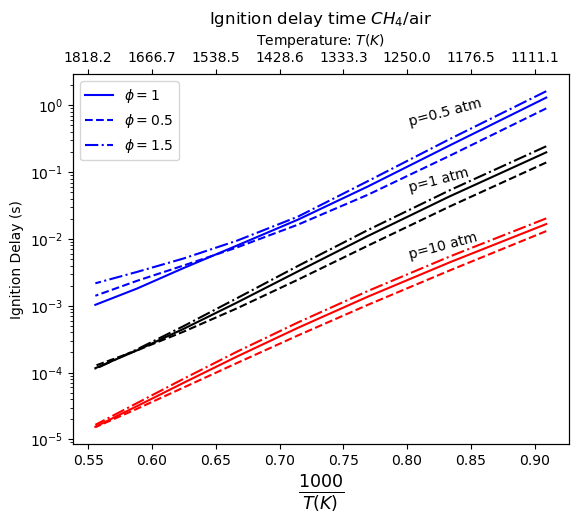

In [284]:
fig = plt.figure()
ax = fig.add_subplot(111)
# plot 0.1bar 
ax.semilogy(1000 / Temp_array, ignition_delays_phi1_p[:8], "-",label='$\phi=1$', color='blue')
ax.plot(1000/Temp_array,ignition_delays_phi05_p[:8], "--", label='$\phi=0.5$',color='blue')
ax.plot(1000/Temp_array,ignition_delays_phi15_p[:8], "-.", label='$\phi=1.5$',color='blue')

ax.set_ylabel("Ignition Delay (s)")
ax.set_xlabel(r"$\frac{1000}{T (K)}$", fontsize=18)


# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000 / ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel("Temperature: $T(K)$");
plt.title('Ignition delay time $CH_4$/air')

ax.plot(1000 /Temp_array, ignition_delays_phi1_p[8:16], "-", color='black')
ax.plot(1000/ Temp_array,ignition_delays_phi05_p[8:16], "--",color='black')
ax.plot(1000/ Temp_array,ignition_delays_phi15_p[8:16], "-.", color='black')

ax.plot(1000 / Temp_array, ignition_delays_phi1_p[16:24], "-", color='red')
ax.plot(1000/ Temp_array,ignition_delays_phi05_p[16:24], "--", color='red')
ax.plot(1000/ Temp_array,ignition_delays_phi15_p[16:24], "-.", color='red')

plt.text(0.8,0.5, 'p=0.5 atm',rotation=15)
plt.text(0.8,0.05,'p=1 atm',rotation=15)
plt.text(0.8,0.005,'p=10 atm',rotation=15)
ax.legend()

fig.savefig('IDT_complete.jpg', format='jpg',bbox_inches='tight')